In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.api as sm
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.cluster.vq import vq, kmeans

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [3]:
combine_clean  = pd.read_pickle("../datasets/filtered_nfl_combine_ch8_plays.pkl")

In [5]:
# ----------------------
# Principal Component Analysis (PCA)
# ----------------------
# Scale data and fit PCA
cols_to_impute = ["Ht", "Wt", "40yd", "Vertical", 
                 "Bench", "Broad Jump", "3Cone", "Shuttle"]
scaler = combine_clean[cols_to_impute].apply(
    lambda x: (x - x.mean()) / x.std()
)

pca = PCA(n_components=8, svd_solver="full")
pca_results = pca.fit_transform(scaler)

# Add PCA components to dataframe
pca_cols = [f"PC{i+1}" for i in range(pca_results.shape[1])]
combine_pca = pd.concat([
    combine_clean,
    pd.DataFrame(pca_results, columns=pca_cols)
], axis=1)

# ----------------------
# K-Means Clustering
# ----------------------
# Cluster using first two principal components
NUM_CLUSTERS = 6
cluster_centers, _ = kmeans(combine_pca[["PC1", "PC2"]], NUM_CLUSTERS, seed=1234)
combine_pca["Cluster"], _ = vq(combine_pca[["PC1", "PC2"]], cluster_centers)

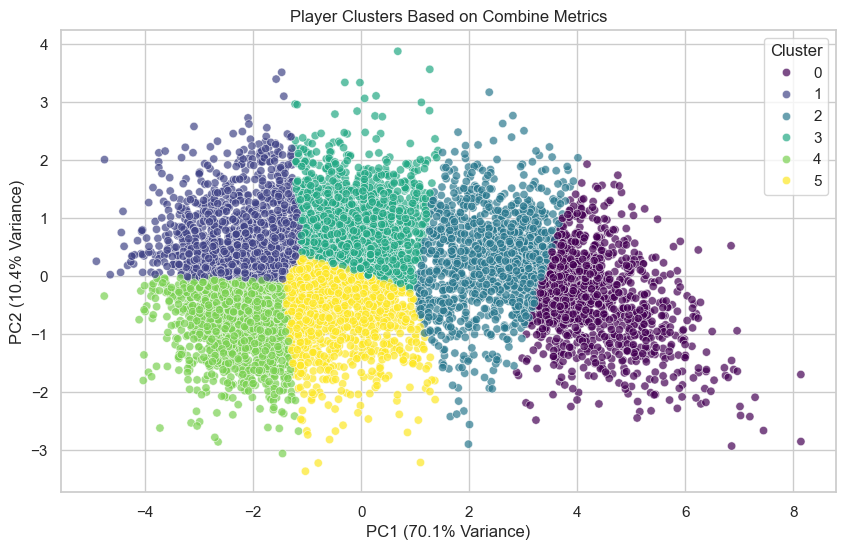

In [6]:
# ----------------------
# Visualization
# ----------------------
# Set visual style
sns.set_theme(style="whitegrid", palette="colorblind")

# Plot PCA components colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=combine_pca,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.7
)
plt.title("Player Clusters Based on Combine Metrics")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% Variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% Variance)")
plt.show()


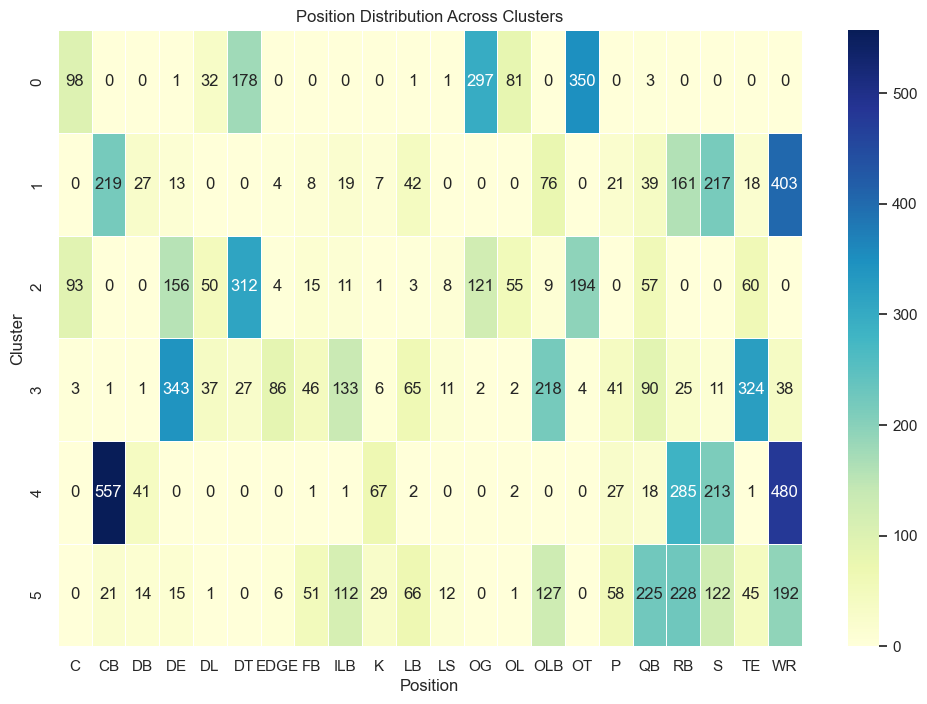

In [7]:


# Position distribution by cluster
cluster_summary = combine_pca.groupby(["Cluster", "Pos"]).size().unstack().fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(
    cluster_summary,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=.5
)
plt.title("Position Distribution Across Clusters")
plt.xlabel("Position")
plt.ylabel("Cluster")
plt.show()